In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext.legacy.datasets import Multi30k
from torchtext.legacy.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

import random
import math
import time

In [3]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

In [5]:
def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings
    """
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]
SRC = Field(tokenize = tokenize_de, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            include_lengths = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)


In [6]:
train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), 
                                                    fields = (SRC, TRG))
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

In [7]:
BATCH_SIZE = 128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     sort_within_batch = True,
     sort_key = lambda x : len(x.src),
     device = device)

In [8]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        self.fc = nn.Linear(enc_hid_dim*2, dec_hid_dim)
        self.dropout = nn.Dropout(dropout)
    def forward(self, src, src_len):
        #src = [src len, batch size]
        #src_len = [batch size]
        embedded = self.dropout(self.embedding(src))
        #embedded = [src len, batch size, emb dim]
        # need to explicitly put lengths on cpu!
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, src_len.to('cpu'))
        packed_outputs, hidden = self.rnn(packed_embedded)
        #packed_outputs is a packed sequence containing all hidden sates
        #hidden is now from the final non-padded element in the batch
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs)
        #outputs is now a non-packed sequence, all hidden satates obtained
        # when the input is a pad token are all zeros
        # outputs = [src len, batch size, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]
        # hidden is stacked [forward 1, backward 1, forward 2, backward 2, ....]
        # outputs are always from the last layer
        #hidden [-2, :, : ] is the last of the forwards RNN 
        #hidden [-1, :, : ] is the last of the backwards RNN
        #initial decoder hidden is final hidden state of the forwards and backwards 
        #  encoder RNNs fed through a linear layer
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        #outputs = [src len, batch size, enc hid dim * 2]
        #hidden = [batch size, dec hid dim]
        return outputs, hidden

In [9]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        self.attn = nn.Linear((enc_hid_dim*2)+dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias= False)
    def forward(self, hidden, encoder_outputs, mask):
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src_len, batch size, enc_hid_dim*2]
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        #print(hidden.shape, batch_size, src_len)
        #repeat decoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        #print(hidden.shape)
        encoder_outputs = encoder_outputs.permute(1,0,2)
        #print(hidden.shape, encoder_outputs.shape)
        #hidden = [batch size, src len, dec hid dim]
        #encoder_outputs = [batch size, src len, enc hid dim*2]
        #print(torch.cat((hidden, encoder_outputs), dim=2).shape)
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        #print(energy.shape,energy.squeeze(2).shape)
        #energy = [batch size, src len, dec hid dim]
        attention = self.v(energy).squeeze(2)
        #print(attention.shape)
        #attention = [batch size, src len]
        #attention = attention.masked_fill(mask ==0, -1e10)
        return F.softmax(attention, dim=1)

enc_hid_dim = 25
dec_hid_dim = 30
attn = Attention(enc_hid_dim, dec_hid_dim)

hidden = torch.FloatTensor(np.zeros([6,30]))#这里要用float类型的tensor， torch.LongTensor是int64
encoder_outputs = torch.FloatTensor(np.ones([10,6,25*2]))
mask = torch.LongTensor(np.ones([6,10]))

at = attn(hidden, encoder_outputs, mask)
at.shape
#hidden.dtype #= torch.long

torch.Size([6, 10])

In [10]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU((enc_hid_dim*2) + emb_dim, dec_hid_dim)
        self.fc_out = nn.Linear((enc_hid_dim*2) + dec_hid_dim + emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
    def forward(self, inputs, hidden, encoder_outputs, mask):
        # input = [batch size]
        # hidden = [batch size, dec hid dim]
        # encoder_outputs = [src_len, batch size, enc hid dim*2]
        # mask = [batch size, src len]
        inputs = inputs.unsqueeze(0)
        #print(inputs.shape)
        
        #input = [1, batch size]
        embedded = self.dropout(self.embedding(inputs))
        #print(embedded.shape)
        #print(hidden.shape,encoder_outputs.shape,mask.shape)
        #embedded = [1, batch size, emb dim]
        a = self.attention(hidden, encoder_outputs, mask)
        #print(a.shape)
        # a = [batch size, src len]
        a = a.unsqueeze(1)
        #a = [batch size, 1, src len]
        encoder_outputs = encoder_outputs.permute(1,0,2)
        #print(a.shape, encoder_outputs.shape)
        # encoder outputs = [batch size, src len, enc hid dim*2]
        weighted = torch.bmm(a, encoder_outputs)
        #print(weighted.shape)
        # weighted = [batch size,1, enc hid dim*2]
        weighted = weighted.permute(1,0,2)
        # weighted = [1, batch size, enc hid dim*2 +emb dim]
        rnn_input = torch.cat((embedded, weighted), dim =2)
        # rnn_input = [1, batch size, enc hid dim*2 + emb dim]
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        #output = [seq len, batch size, dec hid dim*n directions]
        # hidden = [n layers *n directions, batch size, dec hid dim]
        # 
        # #seq len, n layers and n directions will always be 1 in this decoder, therefore:
        # output = [1, batch size, dec hid dim]\
        # hidden =  [1, batch size, dec hid dim]
        # this also means that output == hidden
        assert (output == hidden).all()

        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)

        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim=1))
        # prediction = [batch size, output dim]
        return prediction, hidden.squeeze(0), a.squeeze(1)

# input = [batch size]
# hidden = [batch size, dec hid dim]
# encoder_outputs = [src_len, batch size, enc hid dim*2]
# mask = [batch size, src len]
enc_hid_dim = 25
dec_hid_dim = 30

dec = Decoder(len(TRG.vocab), 10, enc_hid_dim, dec_hid_dim, 0.5, attn)


inputs = torch.LongTensor(np.ones([6]))
hidden = torch.FloatTensor(np.zeros([6,30]))#这里要用float类型的tensor， torch.LongTensor是int64
encoder_outputs = torch.FloatTensor(np.ones([10,6,25*2]))
mask = torch.LongTensor(np.ones([6,10]))
res = dec(inputs, hidden, encoder_outputs, mask)


In [11]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
dec.apply(init_weights)

Decoder(
  (attention): Attention(
    (attn): Linear(in_features=80, out_features=30, bias=True)
    (v): Linear(in_features=30, out_features=1, bias=False)
  )
  (embedding): Embedding(5893, 10)
  (rnn): GRU(60, 30)
  (fc_out): Linear(in_features=90, out_features=5893, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [12]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.device = device
    def create_mask(self, src):
        mask = (src != self.src_pad_idx).permute(1,0)
        return mask
    def forward(self, src, src_len, trg, teacher_forcing_ratio = 0.5):
        # src = [src len, batch size]
        # src_len = [batch size]
        # trg = [trg len, batch size]
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim

        # tensor to store decoder outputs
        outputs =  torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)

        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src, src_len)

        # first input to the decoder is the <sos> tokens
        input = trg[0,:]

        mask = self.create_mask(src)
        # mask = [batch size, src len]

        for t in range(1, trg_len):
            output,hidden,_  = self.decoder(input, hidden, encoder_outputs, mask)

            # place predictions in a tensor holding predictions for each token
            outputs[t] = output

            #decide if we are going to use teahcer forcing or not
            teacher_force = random.random()<teacher_forcing_ratio

            top1 = output.argmax(1)

            input = trg[t] if teacher_force else top1
        return outputs


        

In [13]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, SRC_PAD_IDX, device).to(device)

In [14]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7853, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(5893, 256)
    (rnn): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=5893, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [15]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 20,518,405 trainable parameters


In [16]:
optimizer = optim.Adam(model.parameters())

In [17]:
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [18]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        src, src_len = batch.src
        trg = batch.trg
        optimizer.zero_grad()
        output = model(src, src_len, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [19]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            src, src_len = batch.src
            trg = batch.trg
            output = model(src, src_len, trg, 0) #turn off teacher forcing
            
            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)
            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]
            loss = criterion(output, trg)
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [20]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [21]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut4-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 44s
	Train Loss: 5.038 | Train PPL: 154.132
	 Val. Loss: 4.751 |  Val. PPL: 115.643
Epoch: 02 | Time: 0m 39s
	Train Loss: 4.110 | Train PPL:  60.919
	 Val. Loss: 4.115 |  Val. PPL:  61.278
Epoch: 03 | Time: 0m 39s
	Train Loss: 3.354 | Train PPL:  28.624
	 Val. Loss: 3.629 |  Val. PPL:  37.677
Epoch: 04 | Time: 0m 40s
	Train Loss: 2.861 | Train PPL:  17.486
	 Val. Loss: 3.407 |  Val. PPL:  30.172
Epoch: 05 | Time: 0m 40s
	Train Loss: 2.482 | Train PPL:  11.961
	 Val. Loss: 3.243 |  Val. PPL:  25.617
Epoch: 06 | Time: 0m 41s
	Train Loss: 2.185 | Train PPL:   8.895
	 Val. Loss: 3.310 |  Val. PPL:  27.397
Epoch: 07 | Time: 0m 40s
	Train Loss: 1.948 | Train PPL:   7.016
	 Val. Loss: 3.146 |  Val. PPL:  23.243
Epoch: 08 | Time: 0m 41s
	Train Loss: 1.745 | Train PPL:   5.727
	 Val. Loss: 3.262 |  Val. PPL:  26.093
Epoch: 09 | Time: 0m 40s
	Train Loss: 1.583 | Train PPL:   4.871
	 Val. Loss: 3.217 |  Val. PPL:  24.953
Epoch: 10 | Time: 0m 40s
	Train Loss: 1.471 | Train PPL

In [22]:
model.load_state_dict(torch.load('tut4-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 3.176 | Test PPL:  23.954 |


In [23]:
print('test')

test


In [32]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):

    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('de')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)

    src_len = torch.LongTensor([len(src_indexes)])
    
    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor, src_len)

    mask = model.create_mask(src_tensor)
        
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    attentions = torch.zeros(max_len, 1, len(src_indexes)).to(device)
    
    for i in range(max_len):

        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
                
        with torch.no_grad():
            output, hidden, attention = model.decoder(trg_tensor, hidden, encoder_outputs, mask)

        attentions[i] = attention
            
        pred_token = output.argmax(1).item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attentions[:len(trg_tokens)-1]

In [33]:
def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=15)
    
    x_ticks = [''] + ['<sos>'] + [t.lower() for t in sentence] + ['<eos>']
    y_ticks = [''] + translation
     
    ax.set_xticklabels(x_ticks, rotation=45)
    ax.set_yticklabels(y_ticks)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [34]:
example_idx = 12

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['ein', 'schwarzer', 'hund', 'und', 'ein', 'gefleckter', 'hund', 'kämpfen', '.']
trg = ['a', 'black', 'dog', 'and', 'a', 'spotted', 'dog', 'are', 'fighting']


In [35]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'black', 'dog', 'and', 'a', 'spotted', 'dog', 'fighting', '.', '<eos>']


D:\SoftInstall\Anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app
D:\SoftInstall\Anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()


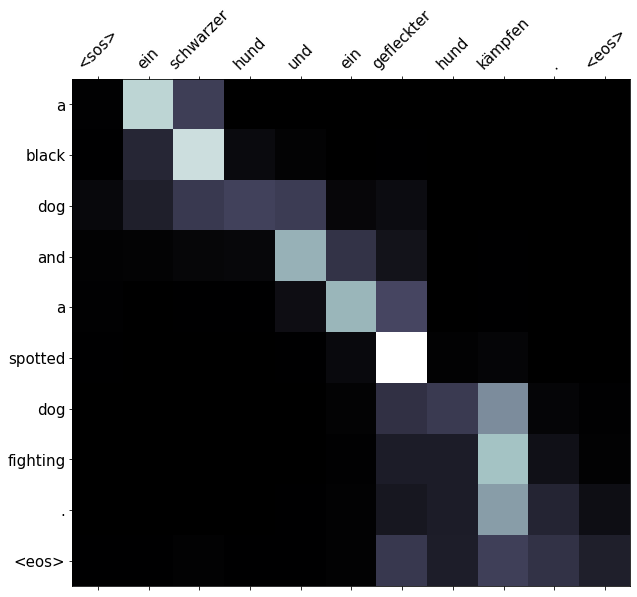

In [36]:
display_attention(src, translation, attention)

In [37]:
example_idx = 14

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['eine', 'frau', 'spielt', 'ein', 'lied', 'auf', 'ihrer', 'geige', '.']
trg = ['a', 'female', 'playing', 'a', 'song', 'on', 'her', 'violin', '.']


predicted trg = ['a', 'woman', 'is', 'playing', 'song', 'on', 'the', 'violin', '.', '<eos>']


D:\SoftInstall\Anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app
D:\SoftInstall\Anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()


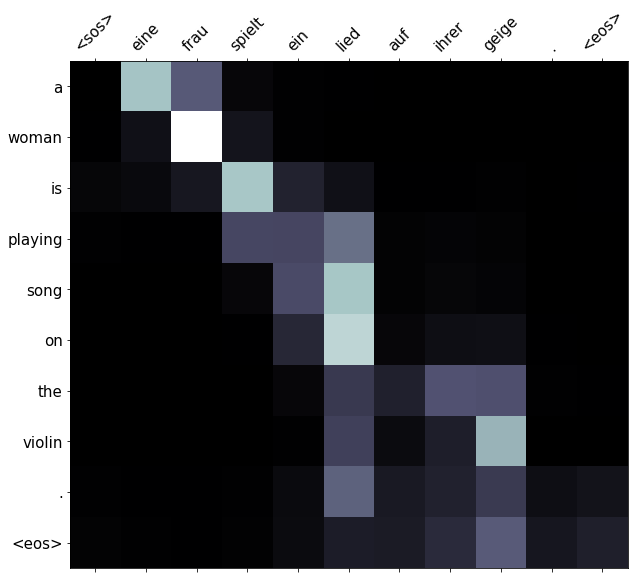

In [38]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

display_attention(src, translation, attention)

In [39]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

In [40]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 29.34
